### Notebook for the label transfer of Reference small dataset (GCA+stem cells) to rest of GCA using `scANVI`

- **Developed by:** Anna Maguxa
- **Institute of Computational Biology - Computational Health Department - Helmholtz Munich**
- 17th February 2022

The main difference of this notebook with other scANVI_label_transferring_on_GCA.ipynb is that in this notebook another reference dataset is used, which has less plasma cells.

### Import required modules

In [1]:
import scvi
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

Global seed set to 0
/home/icb/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/icb/anna.maguza/miniconda3/envs/scvi_env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


### Set up working environment

In [2]:
%matplotlib inline

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
absl                NA
asttokens           NA
attr                22.1.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.5
brotli              NA
certifi             2022.09.24
cffi                1.15.1
charset_normalizer  2.1.1
chex                0.1.5
contextlib2         NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
defusedxml          0.7.1
deprecate           0.3.2
docrep              0.3.2
entrypoints         0.4
executing           1.2.0
flax                0.6.2
fsspec              2022.11.0
google              NA
h5py                3.7.0
hypergeom_ufunc     NA
idna                3.4
ipykernel           6.17.1
ipython_genutils    0.2.0
ipywidgets          8.0.2
jax                 0.3.25
jaxlib              0.3.25
jedi                0.18.2
joblib              1.2.0
jupyt

In [4]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Global seed set to 1712


In [5]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Reference object

In [5]:
reference_input = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/Reference_map_subset_after_geosketch2_less_plasma.h5ad'
reference_output = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/Reference_map_subset_after_geosketch_output.h5ad'

In [6]:
reference = sc.read_h5ad(reference_input)
reference.X

<116562x40144 sparse matrix of type '<class 'numpy.float32'>'
	with 238026331 stored elements in Compressed Sparse Row format>

In [7]:
reference.obs

,UniqueCell_ID,Sample_ID,CellType,Study_name,Diagnosis,Age,Region code,Fraction,Gender,10X,...,doublet_scores,predicted_doublets,Age_group,Integrated_05,total_counts_ribo,Location,n_counts,percent_mito,percent_ribo,Subject
cell_id,,,,,,,,,,,,,,,,,,,,,
AACACGTTCTTGCATT_Ileum-1_Stem Cell,AACACGTTCTTGCATT_Ileum-1_Stem Cell,Ileum-1,Stem Cell,Wang,Healthy adult,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
AACCGCGCATGAAGTA_Ileum-1_Stem Cell,AACCGCGCATGAAGTA_Ileum-1_Stem Cell,Ileum-1,Stem Cell,Wang,Healthy adult,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
AACTCAGAGCGATCCC_Ileum-1_Stem Cell,AACTCAGAGCGATCCC_Ileum-1_Stem Cell,Ileum-1,Stem Cell,Wang,Healthy adult,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
AACTCCCTCTCAACTT_Ileum-1_Stem Cell,AACTCCCTCTCAACTT_Ileum-1_Stem Cell,Ileum-1,Stem Cell,Wang,Healthy adult,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
AACTCTTAGCTTCGCG_Ileum-1_Stem Cell,AACTCTTAGCTTCGCG_Ileum-1_Stem Cell,Ileum-1,Stem Cell,Wang,Healthy adult,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTAAGGATT-1-4918STDY7714150,nan,T036-TIL-SC-EPCAMP,Epithelial,Gut Cell Atlas,Pediatric healthy,4,TIL,SC-EPCAMP,M,3',...,0.04441988950276243,False,Pediatric,Enterocyte,502.0,SmallInt,3636.0,22.45515,13.80638,T036POS
TTTGTCAGTAGAGGAA-1-4918STDY7714150,nan,T036-TIL-SC-EPCAMP,Epithelial,Gut Cell Atlas,Pediatric healthy,4,TIL,SC-EPCAMP,M,3',...,0.11661683041435288,False,Pediatric,Enterocyte,214.0,SmallInt,2822.0,48.91708,7.583274,T036POS
TTTGTCAGTCTAGAGG-1-4918STDY7714150,nan,T036-TIL-SC-EPCAMP,Epithelial,Gut Cell Atlas,Pediatric healthy,4,TIL,SC-EPCAMP,M,3',...,0.11661683041435288,False,Pediatric,Enterocyte,758.0,SmallInt,4088.0,20.332708,18.542074,T036POS


In [8]:
reference.obs['seed_labels'] = reference.obs['CellType'].copy()

### Read query object

In [9]:
query_input = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/Query_map_after_geosketch2_less_plasma.h5ad'
query_output = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/Query_map_after_geosketch2_less_plasma_output.h5ad'

In [10]:
query = sc.read_h5ad(query_input)
query.X

<258731x40144 sparse matrix of type '<class 'numpy.float32'>'
	with 411500554 stored elements in Compressed Sparse Row format>

In [11]:
query.obs['seed_labels'] = 'Unknown'

In [12]:
# Concatenate reference and query
adata = reference.concatenate(query, batch_key = 'dataset', batch_categories = ['reference', 'query'])

### Select HVGs

In [13]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

### Transfer of annotation with scANVI

In [14]:
scvi.model.SCVI.setup_anndata(adata, batch_key = 'Sample_ID', labels_key = "seed_labels", layer = 'counts')

In [15]:
scvi_model = scvi.model.SCVI(adata, n_latent = 50, n_layers = 3, dispersion = 'gene-batch', gene_likelihood = 'nb')

In [16]:
scvi_model.train(100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|█| 100/100 [1:52:49<00:00, 66.63s/it, loss=4.98e+03, v_num=1

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█| 100/100 [1:52:49<00:00, 67.69s/it, loss=4.98e+03, v_num=1


### Label transfer with `scANVI` 

In [17]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [18]:
scanvi_model.train(25)

INFO     Training for 25 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25/25: 100%|█████| 25/25 [55:11<00:00, 133.55s/it, loss=5.07e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25: 100%|█████| 25/25 [55:11<00:00, 132.47s/it, loss=5.07e+03, v_num=1]


In [19]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [20]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

In [21]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 2, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:40)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:15:37)


In [22]:
adata.obs

,UniqueCell_ID,Sample_ID,CellType,Study_name,Diagnosis,Age,Region code,Fraction,Gender,10X,...,Location,n_counts,percent_mito,percent_ribo,Subject,seed_labels,dataset,_scvi_batch,_scvi_labels,C_scANVI
cell_id,,,,,,,,,,,,,,,,,,,,,
AACACGTTCTTGCATT_Ileum-1_Stem Cell-reference,AACACGTTCTTGCATT_Ileum-1_Stem Cell,Ileum-1,Stem Cell,Wang,Healthy adult,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,Stem Cell,reference,101,8,Epithelial
AACCGCGCATGAAGTA_Ileum-1_Stem Cell-reference,AACCGCGCATGAAGTA_Ileum-1_Stem Cell,Ileum-1,Stem Cell,Wang,Healthy adult,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,Stem Cell,reference,101,8,Epithelial
AACTCAGAGCGATCCC_Ileum-1_Stem Cell-reference,AACTCAGAGCGATCCC_Ileum-1_Stem Cell,Ileum-1,Stem Cell,Wang,Healthy adult,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,Stem Cell,reference,101,8,Epithelial
AACTCCCTCTCAACTT_Ileum-1_Stem Cell-reference,AACTCCCTCTCAACTT_Ileum-1_Stem Cell,Ileum-1,Stem Cell,Wang,Healthy adult,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,Stem Cell,reference,101,8,Epithelial
AACTCTTAGCTTCGCG_Ileum-1_Stem Cell-reference,AACTCTTAGCTTCGCG_Ileum-1_Stem Cell,Ileum-1,Stem Cell,Wang,Healthy adult,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,Stem Cell,reference,101,8,Epithelial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTAGGTCCCACTTG-1-WTDAtest7770719-query,nan,A30-SCL-6-SC-45N-2,Epithelial,Gut Cell Atlas,Healthy adult,20-25,SCL,SC-45N,F,3',...,LargeInt,3985.0,48.206486,1.706399,A30 (398B),Unknown,query,4,10,Epithelial
TTGTAGGTCCTCGCAT-1-WTDAtest7770719-query,nan,A30-SCL-6-SC-45N-2,Epithelial,Gut Cell Atlas,Healthy adult,20-25,SCL,SC-45N,F,3',...,LargeInt,1056.0,10.487674,20.738636,A30 (398B),Unknown,query,4,10,Epithelial
TTTATGCCATGTCGAT-1-WTDAtest7770719-query,nan,A30-SCL-6-SC-45N-2,Epithelial,Gut Cell Atlas,Healthy adult,20-25,SCL,SC-45N,F,3',...,LargeInt,14774.0,6.614223,27.406254,A30 (398B),Unknown,query,4,10,Epithelial


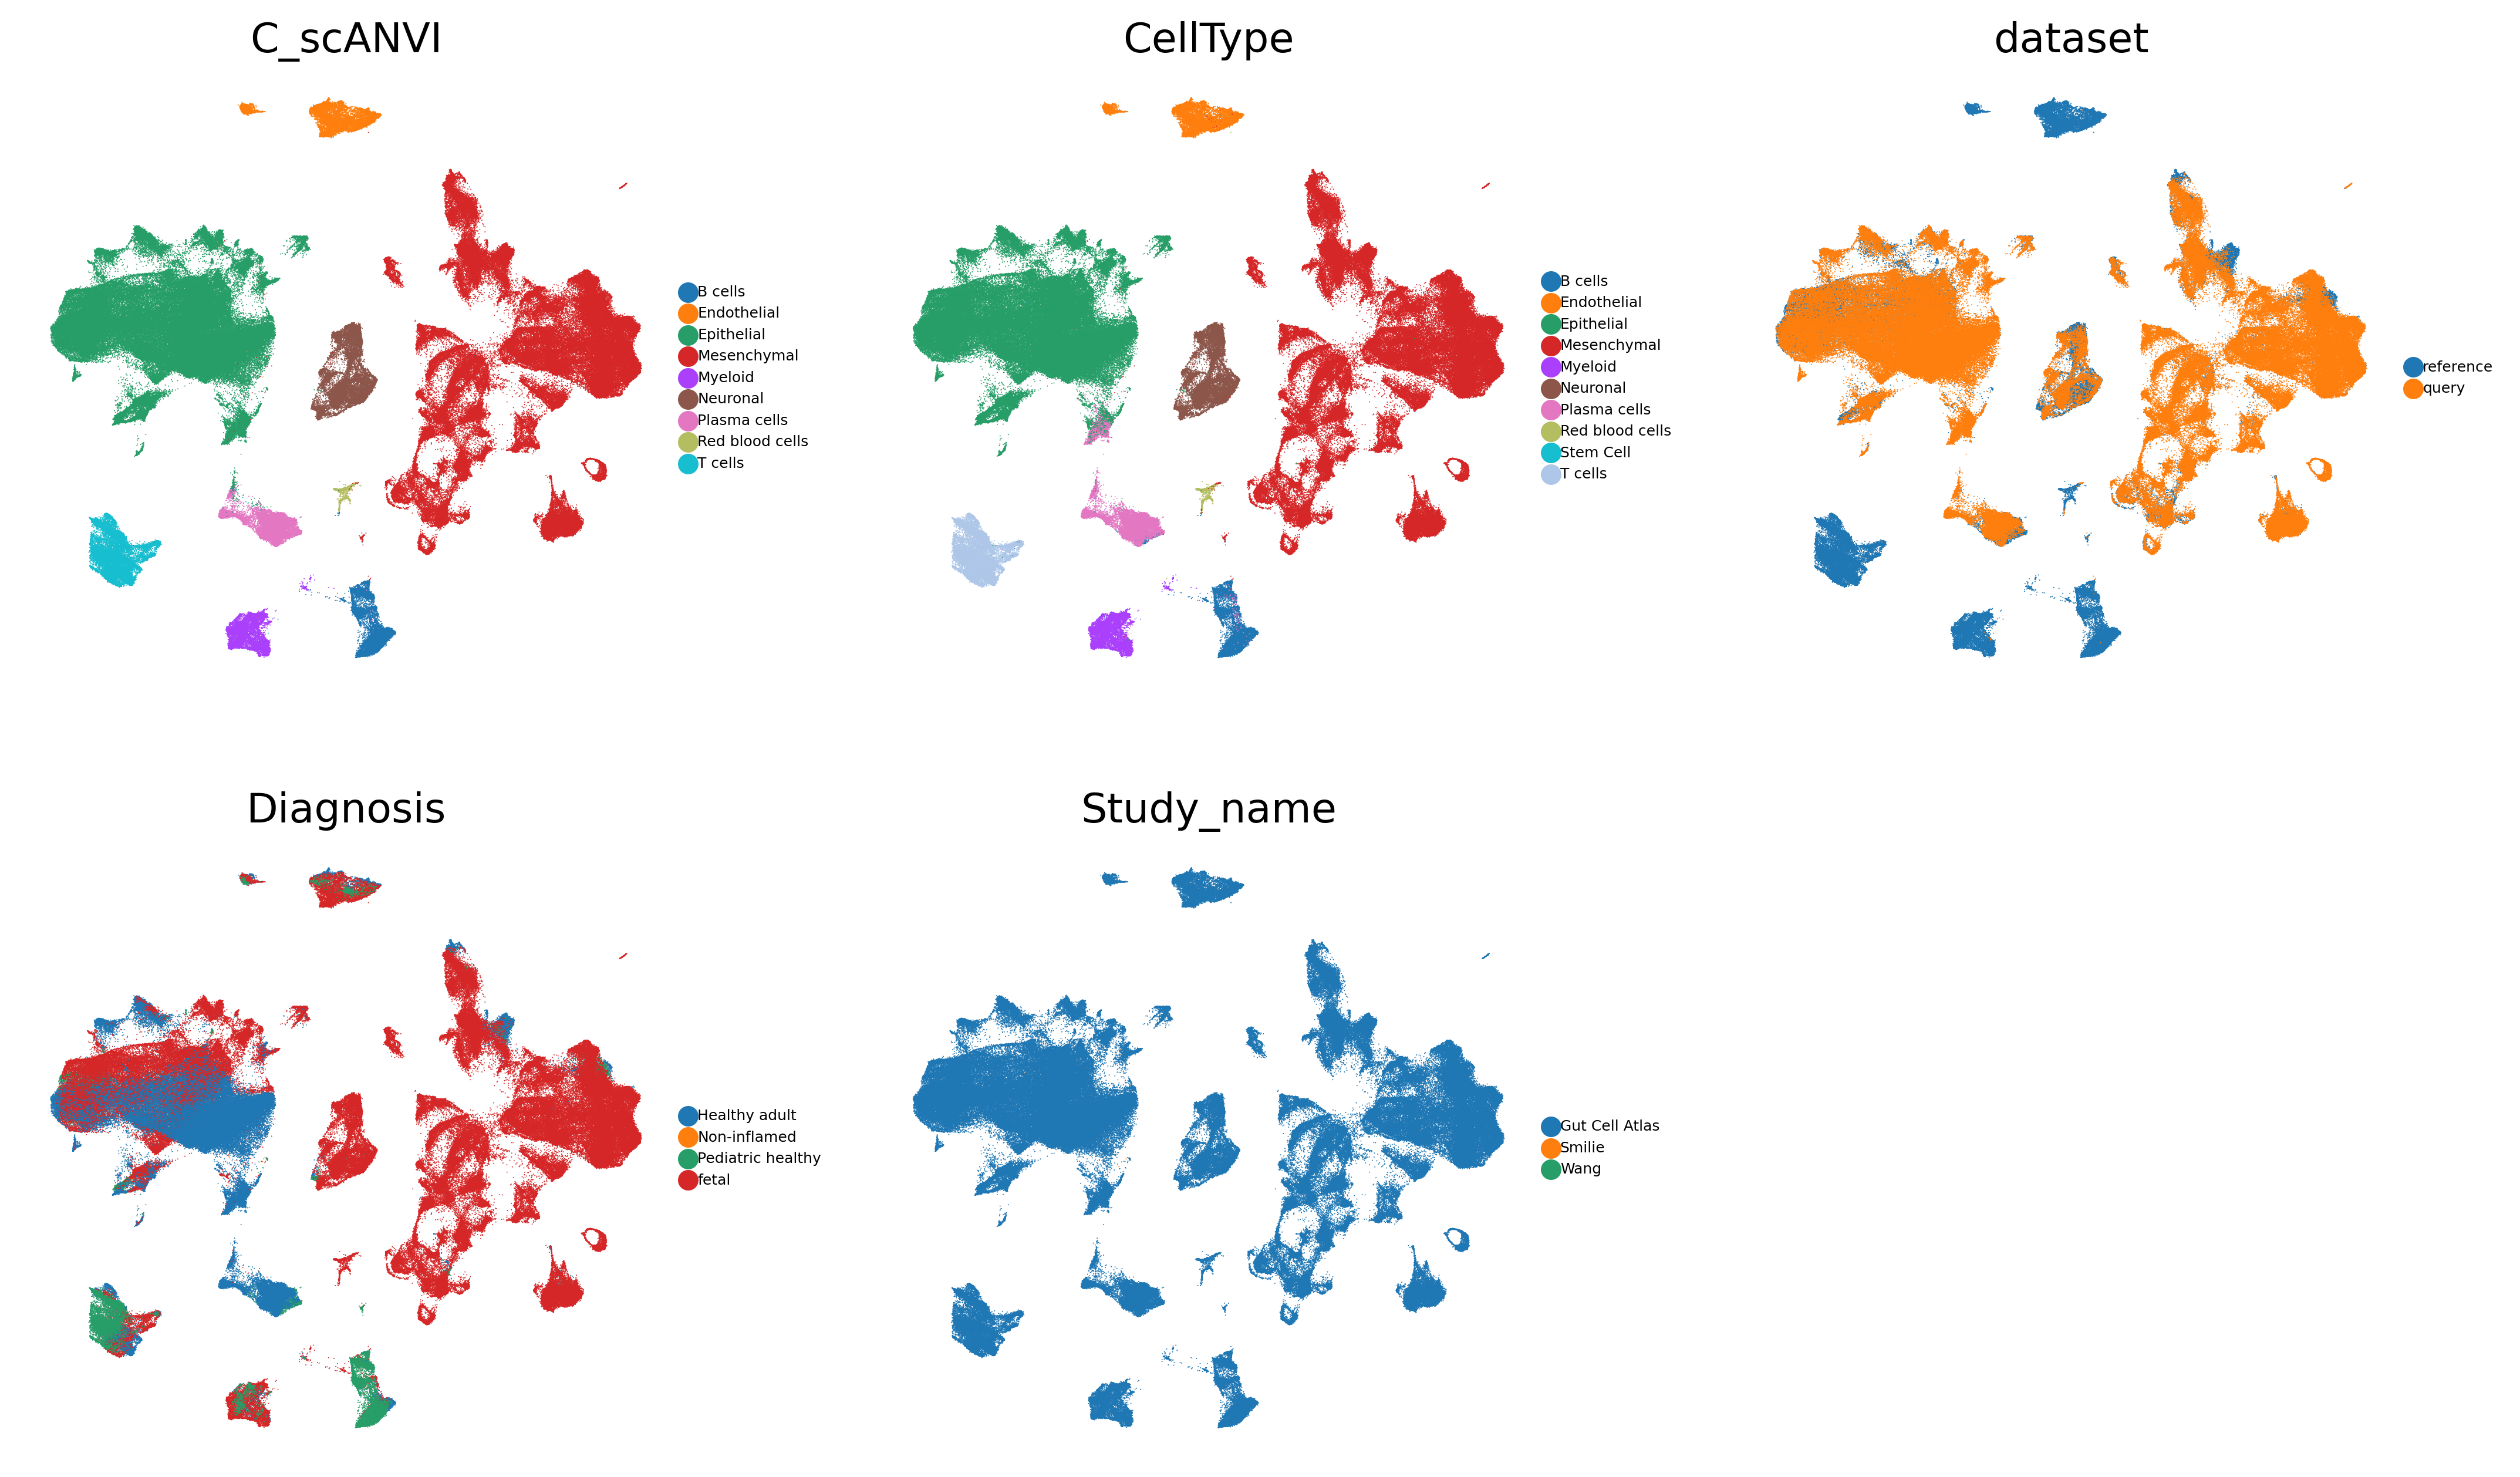

In [13]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'CellType', 'dataset', 'Diagnosis', 'Study_name'], size = 0.6, legend_fontsize = 5, ncols = 3)

In [24]:
#Write anndata object to file
adata.write_h5ad('/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/GCA_Stem_Cell_after_scanvi_less_plasma_cells.h5ad')

### Models Validation

In [6]:
#Read the data
adata_input = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/GCA_Stem_Cell_after_scanvi_less_plasma_cells.h5ad'
adata_output = '/lustre/groups/talaveralopez/workspace/anna.maguza/Processed_datasets/expi_map/GCA_Stem_Cell_after_scanvi_less_plasma_cells_output.h5ad'
adata = sc.read_h5ad(adata_input)

In [9]:
adata.obs['C_scANVI'].value_counts()

Mesenchymal        155759
Epithelial         136185
Neuronal            17622
T cells             17377
Endothelial         13121
Plasma cells        12613
B cells             11413
Myeloid              9836
Red blood cells      1367
Name: C_scANVI, dtype: int64

In [10]:
adata.obs['CellType'].value_counts()

Mesenchymal        155794
Epithelial         129929
Neuronal            17594
T cells             17394
Plasma cells        16445
Endothelial         13082
B cells             11381
Myeloid              9820
Stem Cell            2508
Red blood cells      1346
Name: CellType, dtype: int64

Text(0, 0.5, 'Observed')

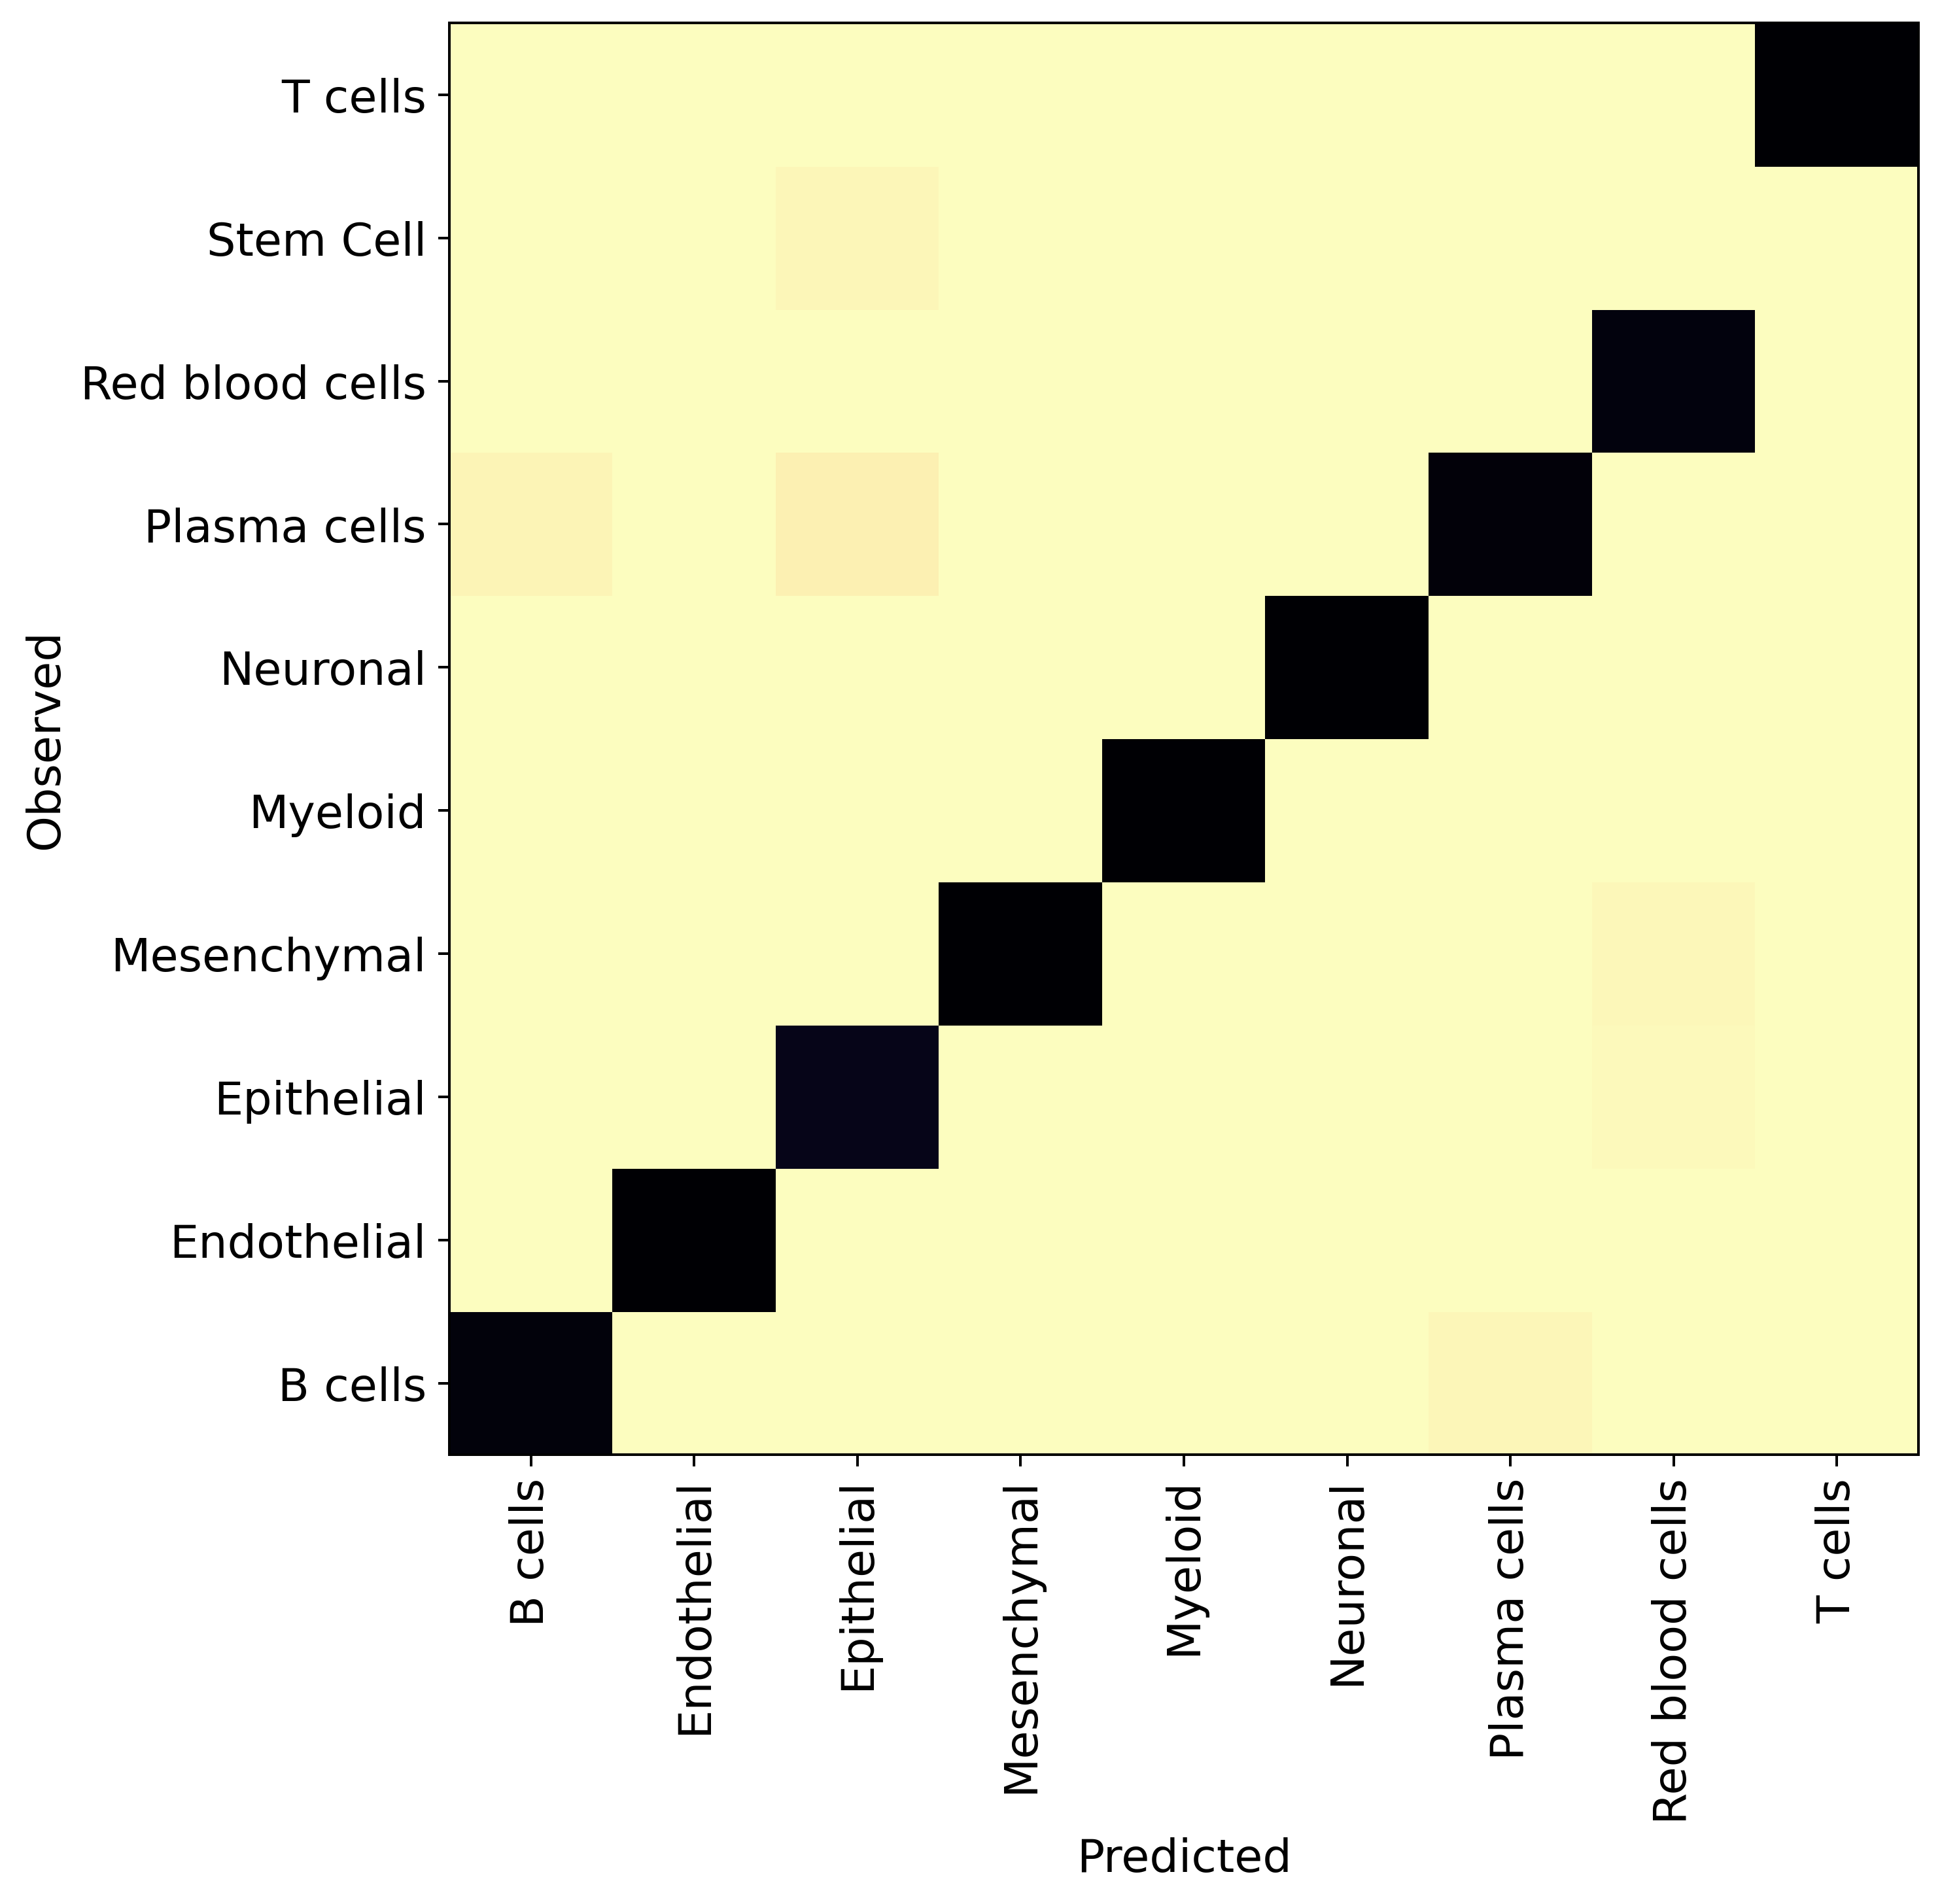

In [11]:
#Validation of the clusters
df = adata.obs.groupby(["CellType", "C_scANVI"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

In [12]:
#Calculate accuracy
print(f"Acc: {np.mean(adata.obs.CellType.cat.codes == adata.obs.C_scANVI.cat.codes)}")

Acc: 0.9348429094067835
